### Library Import

In [66]:
import sys
sys.path.append('../')
import importlib


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from tqdm import tqdm

from sklearn.manifold import TSNE

from lsnc import lsnc
import metrics as mts
importlib.reload(lsnc)
importlib.reload(mts)

## turn off warning
import warnings
warnings.filterwarnings("ignore")

dr_measures = [
	"ls_btw_ch", "lc_btw_ch", "stead", "cohev", "sil",
	"trust", "conti", "mrre_hl", "mrre_lh",
	"kl_div", "dtm"
]
dr_measures_name = [
	"Label-Stretching", "Label-Compression", "Steadiness", "Cohesiveness", "Silhouette",
	"Trustworthiness", "Continuity", "MRRE-HL", "MRRE-LH",
	"KL-Divergence", "DTM"
]
type = [
	"cluster", "cluster", "cluster", "cluster", "cluster",
	"local", "local", "local", "local",
	"global", "global"
]
dr_measures_line_width = [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
linestyle_list = [
	"solid", "solid", "solid", "solid", "solid",
	"dashed", "dashed", "dashed", "dashed",
	"dotted", "dotted"
]
k_cand = [5, 10, 15, 20, 25]
sigma_cand = [0.01, 0.1, 1]

In [40]:
def run_all_metrics(raw, emb, labels, k_cand, sigma_cand):
	"""
	compute all metrics
	"""
	final_results = {}

	## LS & LC
	lsnc_obj = lsnc.LSNC(raw, emb, labels)
	results = lsnc_obj.run()
	final_results["ls_btw_ch"] = results["ls"]
	final_results["lc_btw_ch"] = results["lc"]

	## Steadiness & Cohesiveness
	results = mts.stead_cohev(raw, emb)
	final_results["stead"] = results["stead"]
	final_results["cohev"] = results["cohev"]

	## Silhouette
	final_results["sil"] = mts.silhouette(emb, labels)

	## Trust / Conti / MRRE
	trust, conti, mrre_hl, mrre_lh = 0, 0, 0, 0
	for k in k_cand:
		results = mts.trust_conti_mrre(raw, emb, k = k)
		trust += results["trust"]
		conti += results["conti"]
		mrre_hl += results["mrre_hl"]
		mrre_lh += results["mrre_lh"]
	final_results["trust"] = trust / len(k_cand)
	final_results["conti"] = conti / len(k_cand)
	final_results["mrre_hl"] = mrre_hl / len(k_cand)
	final_results["mrre_lh"] = mrre_lh / len(k_cand)

	## KL / DTM
	kl_div, dtm = 0, 0, 
	for sigma in sigma_cand:
		results = mts.kl_div_rmse_dtm(raw, emb, sigma = sigma)
		kl_div += results["kl_div"]
		dtm += results["dtm"]
	final_results["kl_div"] = kl_div / len(sigma_cand)
	final_results["dtm"] = dtm / len(sigma_cand)
	results = mts.kl_div_rmse_dtm(raw, emb)

	return final_results	

In [81]:
## function to plot the results using seabron (line chart)
def lineplot_results(results_list_dict, title, x_list = None, invert_x_axis=False):

	if (x_list is None):
		x_list = range(1, len(results_list_dict[dr_measure]) + 1)

	plt.figure(figsize=(5.5, 3))
	for i, dr_measure in enumerate(dr_measures):
		plt.plot(
			x_list, results_list_dict[dr_measure], 
			label = dr_measures_name[i], linewidth = dr_measures_line_width[i],
			linestyle=linestyle_list[i]
		)

	if (invert_x_axis):
		plt.gca().invert_xaxis()

	## show legend outside the plot
	plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

	## save fig with high resolution
	plt.tight_layout()
	plt.savefig(f"./plot/{title}.png", dpi=300)

	plt.show()

In [73]:
def compute_metrics(raw, embs, labels, list_num, path):
	results_list_dict = {}
	for dr_measure in dr_measures:
		results_list_dict[dr_measure] = [] 

	for i in tqdm(range(list_num)):
		final_results = run_all_metrics(raw, embs[i], labels, k_cand, sigma_cand)
		for dr_measure in dr_measures:
			results_list_dict[dr_measure].append(final_results[dr_measure])

	for dr_measure in dr_measures:
		results_list_dict[dr_measure] = np.array(results_list_dict[dr_measure])

	## Save the results
	for dr_measure in dr_measures:
		np.save(f"./results/{path}/{dr_measure}.npy", np.array(results_list_dict[dr_measure]))
	
	return results_list_dict

### Experiment 1 (6 hyperspheres and overlapping classes)

In [80]:
raw, labels = np.load("./spheres_data/data/raw.npy"), np.load("./spheres_data/data/label.npy")
embs = []
for i in range(25):
	embs.append(np.load(f"./spheres_data/data/overlapping/circle_{i}.npy"))

100%|██████████| 25/25 [12:08<00:00, 29.15s/it]


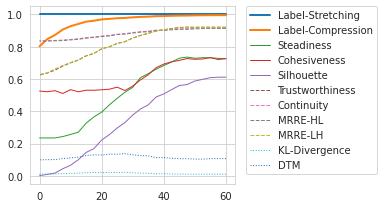

In [82]:
results_list_dict = compute_metrics(raw, embs, labels, 25, "overlapping_circles")
lineplot_results(results_list_dict, "overlapping_circles", x_list = np.linspace(60, 0, 25))

### Experiment 2 (6 hyperspheres and splitting classes)

In [85]:
raw, labels = np.load("./spheres_data/data/raw.npy"), np.load("./spheres_data/data/label.npy")
embs = []
for i in range(25):
	embs.append(np.load(f"./spheres_data/data/splitting/circle_{i}.npy"))

100%|██████████| 25/25 [14:02<00:00, 33.71s/it]


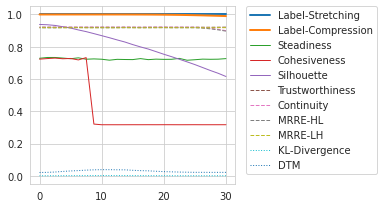

In [86]:
results_list_dict = compute_metrics(raw, embs, labels, 25, "splitting_circles")
lineplot_results(results_list_dict, "splitting_circles", x_list = np.linspace(30, 0, 25))

### Experiment 3 (PCA Expansion test)

#### Currently with digits dataset

In [71]:
## Dataset Generation (with digits data)
raw, labels = load_digits(return_X_y=True)
range_limit = 15
emb_pca = PCA(n_components=range_limit + 5).fit_transform(raw)

embs = []
for i in range(range_limit):
	emb = emb_pca[:, :i+1]
	embs.append(emb)

In [ ]:
## Compute metrics
results_list_dict = compute_metrics(raw, embs, labels, range_limit, "pca_expansion_digits")
lineplot_results(results_list_dict, "pca_expansion")

### Experiment 4 (2D PCA with decreasing component ranks)

#### Currently With digits dataset

In [78]:
## Dataset Generation (with digits data)
raw, labels = load_digits(return_X_y=True)
range_limit = 15
emb_pca = PCA(n_components=range_limit + 5).fit_transform(raw)

embs = []
for i in range(range_limit):
	emb = emb_pca[:, i:i+2]
	embs.append(emb)

100%|██████████| 15/15 [02:53<00:00, 11.60s/it]


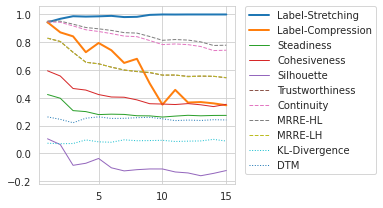

In [79]:
## compute the metrics of the original data and save
results_list_dict = compute_metrics(raw, embs, labels, range_limit, "pca_decreasing_digits")
lineplot_results(results_list_dict, "pca_decreasing")